# Classification of Covid from CT lung images built upon Visual Transformer with Linformer

Training & testing Visual Transformer on *Covid vs nonVovid Data*

* Data are collected from ICCV2021 Workshop MIA-COV19D - https://mlearn.lincoln.ac.uk/mia-cov19d/
* Base Code - Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch
#efficient-attention

In [1]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import torchvision.transforms.functional as TF
from torch.autograd import Variable
import torch.nn.functional as F
import io

#from vit_pytorch.efficient import ViT
#from vit_pytorch.efficient import ViT
from vit_pytorch.vit import ViT
from vit_pytorch.deepvit import DeepViT

def resize2d(img, size):
    return F.adaptive_avg_pool2d(Variable(img),size).data


In [3]:
print(f"Torch: {torch.__version__}")

Torch: 1.8.1+cu102


In [4]:
# Training settings
batch_size = 64
epochs =40 # 40 #40    # 0=no-training, only testing using trained model
lr = 3e-5
gamma = 0.7
seed = 42

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
device = 'cuda'

## Load Data

In [7]:
os.makedirs('data', exist_ok=True)

In [8]:
train_dir = 'data-3d/train-2d'
test_dir = 'data-3d/test-2d'

In [9]:
#with zipfile.ZipFile('train.zip') as train_zip:
    #train_zip.extractall('data')
    
#with zipfile.ZipFile('test.zip') as test_zip:
    #test_zip.extractall('data')

In [10]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [11]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 143338
Test Data: 35091


In [12]:
labels = [path.split('/')[-1].split('_')[0] for path in train_list]

## Random Plots

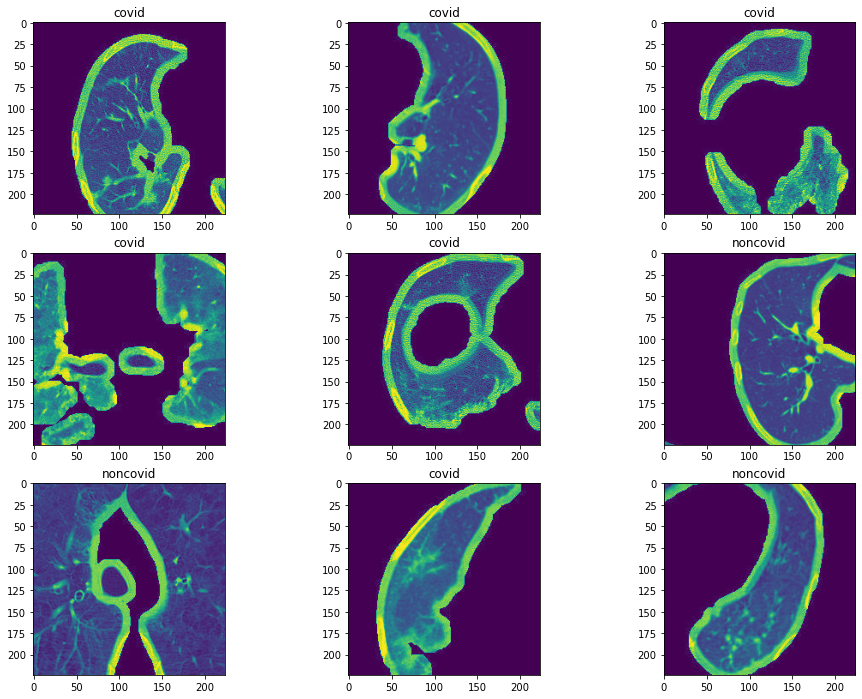

In [13]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [14]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [15]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 114670
Validation Data: 28668
Test Data: 35091


## Image Augumentation

In [16]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [17]:
class CovidDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        #print('2d-img-shape=',img.size,type(img))
        img_transformed = self.transform(img)
        #print('2d-img-shape=',img_transformed.size(),type(img_transformed))
        label = img_path.split("/")[-1].split("_")[0]
        label = 1 if label == "covid" else 0
        return img_transformed, label


In [18]:
train_data = CovidDataset(train_list, transform=train_transforms)
valid_data = CovidDataset(valid_list, transform=test_transforms)
test_data = CovidDataset(test_list, transform=test_transforms)

In [19]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [20]:
print(len(train_data), len(train_loader))
a=train_data[0]
print('train-data-shape=', a[0].shape,a[1],type(a))

114670 1792
train-data-shape= torch.Size([1, 224, 224]) 0 <class 'tuple'>


In [21]:
print(len(valid_data), len(valid_loader))
print(len(test_data), len(test_loader))

28668 448
35091 549


## Effecient Attention

### Linformer

In [22]:
efficient_transformer = Linformer(
    dim=1024,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [23]:
model = ViT(
    dim=1024,
    image_size=224,
    patch_size=32,
    num_classes=2,
    depth=12,
    heads=8,
    mlp_dim=1024,
   # transformer=efficient_transformer,
    channels=1,
).to(device)
## Loading pre-trained model based on all training-dataset
pretrained_net = torch.load('xg_vit_model_covid_2d.pt')
model.load_state_dict(pretrained_net)


sefl= torch.Size([50, 1024]) torch.Size([1, 1024]) Dropout(p=0.0, inplace=False)


<All keys matched successfully>

### Training

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [25]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        # save a checkpoint

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data) 
            #print('val-data, max=',val_output.data[0], torch.max(val_output.data[0],0))
            val_loss = criterion(val_output, label)
            # print the resulrs
            cls = torch.max(val_output[0],0)
            cls = cls.indices
            #print('val-output',cls)
            
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    torch.save(model.state_dict(),'xg_vit_model_covid_2d.pt')   #xg

    """
    # saving the validation data in a batch
with io.open('Vit-val-output-Ep80-TL.txt', 'w') as f:
    for i in range(len(label)):
        if cls>0:
            f.write("%s %s\n" % ('1', int(label[i].data)))
        else:
            f.write("%s %s\n" % ('0', int(label[i].data)))
    """
    

  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.3620 - acc: 0.8334 - val_loss : 0.3819 - val_acc: 0.8235



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.3569 - acc: 0.8334 - val_loss : 0.3853 - val_acc: 0.8199



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.3552 - acc: 0.8345 - val_loss : 0.3705 - val_acc: 0.8291



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.3533 - acc: 0.8353 - val_loss : 0.3670 - val_acc: 0.8290



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.3505 - acc: 0.8373 - val_loss : 0.3687 - val_acc: 0.8289



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.3461 - acc: 0.8385 - val_loss : 0.3674 - val_acc: 0.8308



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.3451 - acc: 0.8388 - val_loss : 0.3620 - val_acc: 0.8328



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.3397 - acc: 0.8421 - val_loss : 0.3591 - val_acc: 0.8331



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.3389 - acc: 0.8427 - val_loss : 0.3499 - val_acc: 0.8378



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.3363 - acc: 0.8447 - val_loss : 0.3569 - val_acc: 0.8363



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.3330 - acc: 0.8460 - val_loss : 0.3447 - val_acc: 0.8416



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.3305 - acc: 0.8470 - val_loss : 0.3433 - val_acc: 0.8400



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.3289 - acc: 0.8478 - val_loss : 0.3498 - val_acc: 0.8374



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.3262 - acc: 0.8494 - val_loss : 0.3423 - val_acc: 0.8392



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.3205 - acc: 0.8505 - val_loss : 0.3499 - val_acc: 0.8381



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.3204 - acc: 0.8523 - val_loss : 0.3383 - val_acc: 0.8444



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.3192 - acc: 0.8524 - val_loss : 0.3382 - val_acc: 0.8454



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.3174 - acc: 0.8529 - val_loss : 0.3318 - val_acc: 0.8471



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.3126 - acc: 0.8561 - val_loss : 0.3338 - val_acc: 0.8451



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.3088 - acc: 0.8578 - val_loss : 0.3341 - val_acc: 0.8457



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.3084 - acc: 0.8577 - val_loss : 0.3371 - val_acc: 0.8484



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.3057 - acc: 0.8596 - val_loss : 0.3214 - val_acc: 0.8523



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.3052 - acc: 0.8589 - val_loss : 0.3297 - val_acc: 0.8494



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.3008 - acc: 0.8609 - val_loss : 0.3253 - val_acc: 0.8521



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.2974 - acc: 0.8623 - val_loss : 0.3189 - val_acc: 0.8532



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.2955 - acc: 0.8634 - val_loss : 0.3312 - val_acc: 0.8480



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.2937 - acc: 0.8652 - val_loss : 0.3234 - val_acc: 0.8515



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.2913 - acc: 0.8660 - val_loss : 0.3170 - val_acc: 0.8548



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.2871 - acc: 0.8696 - val_loss : 0.3201 - val_acc: 0.8528



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.2873 - acc: 0.8677 - val_loss : 0.3137 - val_acc: 0.8585



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.2813 - acc: 0.8712 - val_loss : 0.3281 - val_acc: 0.8522



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.2796 - acc: 0.8724 - val_loss : 0.3129 - val_acc: 0.8562



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.2804 - acc: 0.8708 - val_loss : 0.3060 - val_acc: 0.8606



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.2757 - acc: 0.8718 - val_loss : 0.3080 - val_acc: 0.8585



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.2762 - acc: 0.8730 - val_loss : 0.3003 - val_acc: 0.8634



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.2729 - acc: 0.8742 - val_loss : 0.3088 - val_acc: 0.8579



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.2691 - acc: 0.8772 - val_loss : 0.2996 - val_acc: 0.8653



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.2694 - acc: 0.8767 - val_loss : 0.3031 - val_acc: 0.8617



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.2660 - acc: 0.8777 - val_loss : 0.3015 - val_acc: 0.8642



  0%|          | 0/1792 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.2647 - acc: 0.8782 - val_loss : 0.3038 - val_acc: 0.8611



sefl= torch.Size([50, 1024]) torch.Size([1, 1024]) Dropout(p=0.0, inplace=False)
test-no= 35091
class= torch.return_types.max(
values=tensor(4.0586, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6751, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5281, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3594, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9722, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1634, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8296, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, de

class= torch.return_types.max(
values=tensor(1.4703, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3577, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2426, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2528, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4158, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1745, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1635, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5646, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.7660, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7568, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7541, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6739, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2634, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3014, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9729, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0638, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.9412, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5889, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0200, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3841, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9023, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0493, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6598, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1352, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.1396, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5397, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3649, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4523, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0185, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1047, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2572, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4457, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2512, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2282, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7458, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2926, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0516, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8039, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5294, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.3211, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6036, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3133, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5829, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0514, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5303, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4673, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4261, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.4905, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2090, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6013, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0155, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9171, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4003, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1208, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0855, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.7481, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5261, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0935, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6568, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4017, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5255, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5010, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6665, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.7773, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6818, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8177, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6106, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0771, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4738, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8842, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5836, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.0435, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3048, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2407, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4395, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1300, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1384, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2976, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5969, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(1.1898, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8891, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0739, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4617, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6233, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2858, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3039, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5897, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.2482, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2564, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2878, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7721, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3615, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6577, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3269, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1197, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.7005, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3067, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4904, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5661, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5449, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3992, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6231, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0084, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.5466, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1113, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8563, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2256, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0725, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0053, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3667, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1381, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.6339, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1975, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4232, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3914, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5799, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4131, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2103, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2457, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.4334, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4250, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0149, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4107, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4769, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0941, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6842, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7949, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.7878, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9208, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7511, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4609, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4147, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3906, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4582, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2290, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.8837, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2471, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5833, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9247, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4982, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6520, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8846, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.7593, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1422, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7296, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3372, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2303, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5584, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0038, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8490, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.0180, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0427, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0105, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0458, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6453, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0667, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4623, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7073, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.6761, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2057, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4363, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5793, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5808, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6827, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4022, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4005, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.3174, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4118, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9390, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2294, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2230, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7331, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7759, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6417, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.1923, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1955, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2630, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6132, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9752, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1060, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4361, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2887, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.4260, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3266, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3628, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3411, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7358, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3553, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1492, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2489, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(0.1542, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2496, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6353, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9525, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8892, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9665, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1367, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7126, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.7988, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8934, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5487, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9709, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0725, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4245, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0188, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0479, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.7029, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0698, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1209, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6365, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0214, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6327, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3922, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0667, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.8593, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3908, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2028, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7181, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1675, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2031, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6343, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5607, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(5.0900, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1340, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7645, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6599, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0592, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8464, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1294, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9058, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.5657, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1497, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1519, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9268, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9943, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0062, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2208, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6587, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.1021, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5470, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5037, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6311, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4688, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5984, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0419, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0049, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.5572, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2215, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7552, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5493, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4758, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3707, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6103, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6359, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.9074, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2558, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8978, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4959, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4895, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0053, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5012, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0154, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.8115, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0518, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8308, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3910, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9601, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3691, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6064, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6278, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.0237, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9447, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5187, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3239, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3303, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1653, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5113, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7735, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.9538, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2225, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2537, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2605, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9266, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1646, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0741, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2892, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.2882, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4870, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1537, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0413, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3492, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9992, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1112, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9673, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.3529, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5274, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3446, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6144, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0386, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0575, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6346, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0746, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.7995, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0985, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3375, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4381, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2367, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0616, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9889, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3028, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.3256, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7209, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9147, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4912, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8664, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0493, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3347, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3871, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.7980, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3817, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0289, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3107, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6193, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9338, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4926, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7448, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.0629, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5915, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1759, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(6.0807, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1958, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5694, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5331, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1055, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.1377, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4494, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5360, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7306, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1737, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7119, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1473, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0837, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.8312, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2899, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7046, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3479, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9866, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3447, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5799, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1248, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.0298, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5852, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4792, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7401, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7481, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4039, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6933, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4377, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.2749, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9172, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5630, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2744, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8333, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1506, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1597, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9361, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.7720, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9675, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8386, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4403, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2869, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7378, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8512, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9425, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.4995, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3809, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0004, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1943, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9470, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7908, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6419, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0278, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.1663, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4028, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9316, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9333, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0282, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3543, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9851, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2982, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.2879, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5129, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0376, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2142, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0245, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6280, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7108, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2609, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.6769, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5286, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0339, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7391, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6367, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4461, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7998, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4380, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.1644, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8778, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4815, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1836, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6082, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1944, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0121, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7940, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.5549, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3605, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6433, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0084, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0417, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8238, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9216, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3746, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.1098, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0446, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6750, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8617, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8526, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2114, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5093, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5287, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.1722, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7443, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2207, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1326, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1058, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1446, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9282, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4170, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.7607, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6579, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6450, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1745, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0689, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2636, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9715, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0910, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.8854, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4467, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4557, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2505, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4390, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8475, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3454, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4387, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.9856, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4791, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2517, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5830, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8277, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3867, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1851, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3077, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.6659, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8540, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8256, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4724, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0331, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5915, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4087, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0335, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.3704, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9841, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4174, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2858, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6843, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5721, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2959, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5862, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.5840, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9186, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2644, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7021, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8670, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4718, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4409, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2265, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.3774, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4282, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4830, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7893, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4147, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9347, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6761, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0633, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.5282, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4426, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2293, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8492, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6135, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(6.0707, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9146, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5152, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.6565, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4275, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3116, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0023, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9724, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2800, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4728, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0776, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.1052, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7580, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2543, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1194, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0805, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4071, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3829, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2818, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.4968, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9840, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0976, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2635, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0512, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6194, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6514, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2486, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.9960, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8693, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0093, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2852, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5041, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4748, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5208, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6830, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.1480, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6963, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9607, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5004, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9974, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3840, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6647, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2590, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.4333, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8021, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6705, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1874, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5777, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2711, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0249, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6816, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.2404, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4311, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1825, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8130, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4471, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4925, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9219, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4891, device='cuda:0', grad_fn=<

class= torch.return_types.max(
values=tensor(3.7725, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9445, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4489, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8457, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5856, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7232, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7188, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7071, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(5.7510, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7436, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8033, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0575, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0791, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6602, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8668, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3857, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.7764, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2958, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3626, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7713, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0787, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8263, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3714, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0992, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(5.3583, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0493, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7143, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0904, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7206, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7052, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8738, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6514, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.3211, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8113, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7200, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7819, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5981, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2344, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7911, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0165, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.1233, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1435, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1386, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2841, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4319, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4246, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3803, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5895, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.9567, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5238, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5714, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5669, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0003, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5911, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8237, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6872, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.8162, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9178, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0198, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2693, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8757, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1545, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9189, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2490, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.6760, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7351, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4683, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8345, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5504, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7843, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6440, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3615, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.3579, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8191, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9265, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5583, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5991, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3226, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9614, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4060, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.1421, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8007, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7847, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5017, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8169, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8445, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1934, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1953, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.6838, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3940, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0092, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2874, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8419, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1510, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9647, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7437, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.6687, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6850, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8663, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1662, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3606, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3453, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5032, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8418, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.3202, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3219, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3207, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6883, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9019, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3415, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4705, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4708, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.8995, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6797, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6200, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8542, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7610, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4973, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9628, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2736, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.3542, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4234, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0339, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1359, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3671, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2827, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4368, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0008, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(0.0145, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8373, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3475, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5124, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5122, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9389, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6198, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9284, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.6715, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0955, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9781, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0452, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7752, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7768, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1464, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3867, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.9396, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1271, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2395, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5951, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1477, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7695, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3614, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8150, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.9607, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1258, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6989, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7520, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7603, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8135, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1806, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4981, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.4878, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8190, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2496, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4381, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7076, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5592, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1750, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1140, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.5704, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0139, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2008, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5374, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1571, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4317, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0194, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4132, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.8941, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5805, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4017, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4353, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9207, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7373, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2599, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6404, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.3957, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9032, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9928, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2898, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-1.0647, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4557, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1939, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5418, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.8605, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5299, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3996, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1876, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1149, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1480, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5702, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5973, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(4.3965, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3904, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5104, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8231, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8787, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9468, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2329, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9672, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.4825, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8961, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5348, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8085, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2184, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6192, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3275, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7835, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.1523, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5119, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7381, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2428, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4540, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4220, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5841, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9933, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.4163, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1709, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3517, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1875, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3093, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1842, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5430, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4169, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.2010, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7862, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1965, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7413, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5007, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8337, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5780, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2781, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.9870, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9314, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6511, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1983, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8684, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3128, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4591, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1987, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.7623, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4104, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2240, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0684, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3983, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8520, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4127, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5029, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.4995, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3727, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5673, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2352, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4039, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9921, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0829, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3012, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.7343, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4740, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4077, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4232, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0861, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3055, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.8550, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1198, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.2435, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4298, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7263, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8238, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4148, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7285, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6777, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8256, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.3328, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1387, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0534, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8305, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0012, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0439, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7898, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9608, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.0286, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8980, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5979, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0355, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9895, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1364, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0565, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9239, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.4287, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3202, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5790, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3348, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7505, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5259, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4197, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0307, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.3665, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3364, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3555, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6110, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1911, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5295, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3016, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2248, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.8191, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4396, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8111, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4456, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1836, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9749, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2632, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2993, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(5.4064, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6729, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3667, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1717, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8753, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4736, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7824, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9213, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.8438, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8229, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5135, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9086, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6819, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0737, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3333, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9629, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.7769, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1505, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8287, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5077, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6378, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2024, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8880, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7562, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.9933, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6339, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2035, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1510, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2310, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0775, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5560, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1014, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.6743, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1141, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0948, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4909, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3766, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3571, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2361, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7268, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.3114, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2909, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2530, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1851, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9095, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5704, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2749, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4446, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.8037, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1291, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6054, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8653, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4899, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1925, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3290, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6455, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.6773, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0035, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4388, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3367, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8802, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9241, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2071, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5956, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.5175, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0329, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7539, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3976, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5060, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4702, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1068, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4067, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.4632, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1820, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3899, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7391, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6508, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6128, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0844, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4513, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.8815, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1715, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2968, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4563, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5869, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2393, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2171, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7545, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.5342, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2365, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3063, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6679, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4682, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1081, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8874, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6770, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.4764, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3112, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7006, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9088, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1947, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1896, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7094, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9038, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.8699, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.9254, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2018, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0439, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1592, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3265, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5537, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1343, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.2971, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3449, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4656, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2194, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8792, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6965, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3615, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5197, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.6285, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3551, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9113, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3455, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0002, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3808, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2026, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5309, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.2811, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9459, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1027, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0701, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1142, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5535, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6728, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7833, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.7372, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8219, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4575, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1017, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3429, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0364, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2468, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9058, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.8569, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5428, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3417, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3277, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4136, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5401, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1563, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0349, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(-0.2003, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3571, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8697, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8535, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5230, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3234, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4390, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4342, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.2741, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5947, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2706, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3742, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5431, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2186, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5442, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2270, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.9422, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9710, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1143, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5427, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3767, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1477, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0055, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5401, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.2026, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1459, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4100, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0043, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1783, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2970, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0069, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0193, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(2.5756, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1962, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1899, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4661, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7242, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1155, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7826, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4431, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.6015, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3442, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3457, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4584, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3720, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6032, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3878, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7117, device='cuda:0', grad_fn=<

class= torch.return_types.max(
values=tensor(4.9538, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6278, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6169, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6772, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7305, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5484, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5423, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4047, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.9951, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1727, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9983, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8108, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8874, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3237, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1007, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1707, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.8457, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4338, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4471, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0833, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0377, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6843, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5918, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9091, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.4808, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8169, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0956, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1673, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.7385, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9453, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0243, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3808, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.7286, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0263, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8275, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4912, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6304, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3502, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2018, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2232, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.0302, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3276, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1025, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5314, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9406, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0564, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7895, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2657, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.2313, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7084, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1776, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4878, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2844, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7269, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5213, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4569, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(5.1916, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0208, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2260, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2172, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4770, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9410, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3860, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8858, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.4104, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4635, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5864, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7684, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8749, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8705, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9466, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7181, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.0744, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5417, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5505, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0775, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2080, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1894, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9943, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1742, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.0668, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3786, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5171, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6365, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5953, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3267, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4010, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9609, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.7943, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0821, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5126, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5281, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5280, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7097, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0407, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6034, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.5725, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9090, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5641, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8768, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2552, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0590, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0776, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6748, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.6553, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9686, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6107, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6508, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3286, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9671, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3955, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5642, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.8117, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8806, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9387, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2182, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0919, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0646, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1800, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.7924, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.4102, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6921, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1550, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0751, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4348, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7542, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0983, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5316, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.3730, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2504, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0903, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7212, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9875, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2731, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1447, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5307, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.9244, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7775, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3257, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1272, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3940, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2337, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1156, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4969, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.5387, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6749, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4532, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6129, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0318, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3202, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1473, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5812, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.0057, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5229, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1901, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8844, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3079, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2805, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4018, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5182, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(1.5287, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8722, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9896, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1989, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2256, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6865, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5119, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4097, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.3700, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8935, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3305, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2512, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7277, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9084, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2754, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1492, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.2898, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1868, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2817, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6416, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7230, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7548, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5555, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5741, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(3.0037, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5836, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6934, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1758, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1614, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9520, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6293, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3197, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.1455, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2067, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0431, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9340, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6100, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0176, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8483, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2010, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.0275, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8633, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0016, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3514, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0043, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8241, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7369, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1462, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.0598, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1536, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2463, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3475, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0478, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3754, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5729, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4801, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.2988, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5715, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4092, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3930, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8468, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2695, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6372, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4551, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.3449, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9586, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2766, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0222, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7319, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5688, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5475, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1115, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.1780, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0693, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0092, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5159, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8747, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8258, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2187, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3379, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(0.0541, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0569, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3566, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2075, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5693, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6133, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2377, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1171, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.5919, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1362, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0148, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6887, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5232, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2224, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4149, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5295, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.8699, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3552, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2383, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1702, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6653, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9889, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6690, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2474, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.7944, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0623, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1051, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3239, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2066, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5218, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1106, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5210, device='cuda:0', grad_fn=<Ma

indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4415, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2524, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5453, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5382, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0961, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6025, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1019, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(

class= torch.return_types.max(
values=tensor(1.2537, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5948, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8672, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8790, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0714, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0583, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4185, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1362, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.9127, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0074, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2151, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8287, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2154, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3058, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9748, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8537, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(5.6758, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6763, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0515, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1775, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0449, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8942, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4510, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5554, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.2438, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3671, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6639, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7671, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1160, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0707, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7454, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9356, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.2689, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5016, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5381, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6406, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9163, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1781, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4622, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(6.1987, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.0568, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3664, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6671, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4748, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5789, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4916, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8012, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2686, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.1507, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1509, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7147, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7743, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7334, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6338, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2545, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3070, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.5341, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5036, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6825, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6713, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0545, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0572, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.9193, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2937, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(4.1486, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0837, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0943, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3606, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4264, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2784, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3886, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6217, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.2851, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4626, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2416, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6021, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4049, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4916, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5860, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.9951, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.5244, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(6.2184, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1500, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9957, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0034, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9469, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5837, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4837, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.3177, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6903, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8986, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3529, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6557, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3747, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6198, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1476, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.9290, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9730, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7818, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6616, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2013, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6899, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4047, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1948, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.8690, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3199, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0596, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5114, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2562, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0844, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6993, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6364, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.4847, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4466, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7238, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0728, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0058, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9325, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5295, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8167, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.7660, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5627, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4900, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0979, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1585, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2593, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0944, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9653, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.1125, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5885, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1085, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8254, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7368, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8447, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6772, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0353, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.5161, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0326, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3995, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9025, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9497, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4832, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9198, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6851, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.6145, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7086, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3860, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0596, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9585, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0245, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7926, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6576, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.4228, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5356, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0028, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2667, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8166, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3466, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3286, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9155, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.1988, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9134, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7920, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2681, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3459, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4670, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0960, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4829, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.1752, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0511, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6156, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1345, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0767, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0680, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2527, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9380, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.1482, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7962, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1684, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1945, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5014, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9170, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5667, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4538, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.6252, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7626, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2541, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6440, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6145, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8560, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7835, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0605, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.6821, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4574, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2433, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3552, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1684, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4191, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0524, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8639, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.8539, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0052, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0479, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2402, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2781, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0428, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8845, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3093, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.7454, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8975, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5790, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6924, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4703, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1286, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4462, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5877, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.4110, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2310, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1536, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3796, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7009, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0923, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1700, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8531, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.4118, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6406, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1872, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2208, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2145, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2602, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4155, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8888, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.2623, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9503, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5056, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2882, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5649, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8308, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0292, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6552, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.9835, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5273, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0194, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4447, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3518, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0640, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2866, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1766, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.8045, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6121, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0357, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0020, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1031, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4982, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3138, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9627, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.5818, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1800, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1519, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7097, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2756, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0120, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4621, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0601, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.5644, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6232, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6925, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6052, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3254, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2141, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2246, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2855, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.5029, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8142, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2346, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2470, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8953, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4012, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5537, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6993, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(5.4122, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6612, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3814, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0816, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1022, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5344, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9876, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1144, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.1194, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0387, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8586, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1001, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1955, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2988, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4356, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2641, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.6767, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3041, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1136, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1849, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9919, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0245, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8385, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5719, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.3245, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7007, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5848, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7412, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4241, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9468, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2644, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.7405, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.4668, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4620, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7260, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1375, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8713, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6897, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2699, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8822, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.1340, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4641, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7346, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3300, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0422, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5508, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2876, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0163, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.3511, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4094, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0199, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4239, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1720, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5730, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9153, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3769, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.1477, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0200, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(6.2451, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0027, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9411, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0967, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3396, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3067, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.2642, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3396, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8737, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0675, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6051, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0003, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6984, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0092, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.1180, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6616, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5065, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0246, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1141, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1132, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0170, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6274, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.1401, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3303, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6788, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8349, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2175, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3535, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4318, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9033, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.4636, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4289, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9221, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2629, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1005, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3507, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3384, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6878, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(4.0033, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5919, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9311, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4284, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7480, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3236, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7951, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6031, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.7712, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9604, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5915, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8634, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1671, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2956, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9002, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5264, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.7625, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5525, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6601, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0141, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9987, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6885, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0645, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1833, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.7157, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3905, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2317, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2360, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4544, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2321, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3392, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1426, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.1171, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4111, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1060, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4095, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3914, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6738, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3295, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1456, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.3720, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6771, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0013, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4905, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8305, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9107, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1075, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2766, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.4969, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8950, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1805, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1121, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9917, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9788, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4423, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3056, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.0330, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0558, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6231, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5738, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2497, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8024, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0527, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8168, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.7357, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5993, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5509, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1660, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9159, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3944, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4822, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4192, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.2846, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0763, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4683, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1286, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5535, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4369, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4693, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8669, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.3152, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0023, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0127, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1547, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7070, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3419, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0906, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9789, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(-0.1487, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5065, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5005, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0097, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2832, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6779, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0131, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2963, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(1.1744, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0025, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3479, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4787, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5948, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8296, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5948, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5647, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.1991, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1098, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8945, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1481, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3729, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4164, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2300, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7739, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.9543, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7465, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4430, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9080, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5851, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7372, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0251, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0871, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.8187, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2111, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2985, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1601, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8818, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4853, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1306, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7549, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.6073, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1240, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4594, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7882, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1032, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9729, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9594, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9670, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.9049, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3434, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7676, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3072, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(6.1428, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3485, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1934, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7479, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.4105, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8624, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6862, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0876, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6339, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7217, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7747, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2034, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.7999, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0419, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6984, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6870, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2393, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3188, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4760, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3756, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.2383, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6828, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8341, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9359, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8872, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3332, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8222, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3515, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.8836, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6350, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3699, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0645, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1940, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4411, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0429, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5673, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(0.6976, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0350, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6657, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6685, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2885, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4972, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4266, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3562, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.7189, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5788, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2982, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7081, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1537, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3296, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2195, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2537, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.2920, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0637, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7562, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2583, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0958, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7113, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6543, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3978, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.5938, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5191, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8059, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5015, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7048, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7934, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3512, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3800, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.2643, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0271, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9471, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7486, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9152, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4534, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.7156, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2952, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.8651, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8048, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3627, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5149, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7892, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5172, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3401, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0325, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.6600, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2106, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8392, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1125, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5106, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7742, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3119, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2280, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.4901, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0429, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4078, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6660, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7483, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2176, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0589, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6947, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.2845, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0282, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7357, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7902, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1441, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5864, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0978, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1443, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(4.8110, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6380, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5251, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3746, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1708, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1260, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1943, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3167, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.5916, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4061, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5886, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2205, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0200, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3135, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2411, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0056, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.8626, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.9281, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6444, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6366, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8301, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6293, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0590, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8972, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.5396, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0113, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8589, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6565, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1526, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0774, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2344, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7337, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.5931, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3036, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9433, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4617, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5323, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4362, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4534, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1166, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.6735, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7732, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1090, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0082, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0639, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8545, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0982, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5587, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.8318, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6084, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0118, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7732, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5549, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9445, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3337, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8787, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.3336, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8838, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2479, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5894, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2834, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6320, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9537, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4760, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.3918, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.7205, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2287, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2441, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0677, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0720, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3212, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2642, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.2926, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4076, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5174, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4076, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5007, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6162, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6930, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6235, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.5335, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6396, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8980, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3821, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4730, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9520, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3554, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3589, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.0413, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9225, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8893, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6372, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4988, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1260, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5731, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9857, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.7137, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5655, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3070, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2236, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6447, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0786, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6524, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6404, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.8691, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7263, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5200, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4270, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7647, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2983, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6577, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9351, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.2751, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7908, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9845, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0448, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9767, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7272, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0671, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0039, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.2950, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6185, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5350, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6960, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4131, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0078, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7385, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8523, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.9829, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0491, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3595, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7839, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7988, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7655, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0416, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9433, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.1761, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1814, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2215, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4516, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1306, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6078, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4516, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4218, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.3235, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3041, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2387, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4964, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0205, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9258, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4312, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7741, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.6026, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0838, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4120, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3779, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1510, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9956, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9118, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6813, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.1919, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0141, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1976, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6960, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2795, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5526, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6021, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0887, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(0.9580, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8024, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3907, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4956, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5838, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5775, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5631, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5916, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.4219, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1997, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2146, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1014, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5743, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8099, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2386, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2398, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.5323, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.9208, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6832, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3015, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4837, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6078, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0316, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0836, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.5504, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3532, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4735, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0605, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8504, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6269, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8199, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5008, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.6099, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6768, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2920, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4880, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4136, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6744, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5925, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6010, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.7147, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3076, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7359, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5570, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8795, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9997, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1230, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0064, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.9995, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4118, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3776, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1450, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6537, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7321, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8308, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2273, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.0924, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2246, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1711, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7444, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7874, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8799, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1288, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9498, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.7048, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2473, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9781, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8954, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5985, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4773, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1123, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9890, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.1974, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5435, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8199, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0598, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5742, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4442, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8651, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3006, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.3096, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6075, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0528, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7946, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2623, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0441, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6759, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4278, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.9524, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8387, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4115, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2300, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4999, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9455, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3921, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3589, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.3643, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1407, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0504, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5773, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1708, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5497, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1966, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9888, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.0224, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0318, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.8391, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6192, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5861, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6986, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2956, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5700, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.0578, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1484, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1297, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8212, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8139, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8229, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5952, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6048, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.5922, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1641, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0134, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6950, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4452, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6197, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6436, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5791, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.3351, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2217, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1356, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0316, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1678, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9228, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3270, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4629, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.9929, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2766, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3477, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0360, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3885, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2831, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0829, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6362, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.4454, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9488, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1787, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8660, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4160, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1890, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4270, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0771, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.1054, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8197, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1463, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7540, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9029, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9802, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0854, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3757, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.0138, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5625, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2019, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4084, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6523, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3680, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2000, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7217, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.7869, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5889, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0419, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2345, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0984, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9453, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7905, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8783, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.5923, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4176, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3572, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0688, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3299, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5085, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7659, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0168, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.6392, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7995, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1595, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4754, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3514, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4111, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4276, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6121, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.3669, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1468, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5368, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0837, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6909, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7891, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6310, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1498, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.2272, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7216, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0336, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8875, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2085, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6228, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2836, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4158, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.1237, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0703, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6026, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6087, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3835, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3755, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4729, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1379, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(2.0360, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2685, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0648, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6313, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3885, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8660, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8759, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2781, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.4552, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4692, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1349, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3849, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1184, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1082, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1159, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5597, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.3808, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9854, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3679, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4928, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4771, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3579, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1838, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9092, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.0204, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5571, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4565, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3049, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3994, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2146, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8993, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1027, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.2594, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3403, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6194, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2211, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8814, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2801, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9689, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9845, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.1640, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4281, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3507, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4130, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0552, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0609, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-1.1272, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1779, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.2444, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5201, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0253, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5098, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9440, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7519, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2587, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7939, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.2296, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7685, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4166, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9580, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0800, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1807, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5937, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3626, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.4157, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2106, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4698, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7335, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5215, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9244, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5535, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2678, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.1646, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2216, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4939, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0407, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8453, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6768, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3664, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2137, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.1295, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2811, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5667, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6807, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3604, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3472, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9042, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0325, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.3081, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4574, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9221, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0672, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4749, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0395, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1566, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8593, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.4160, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1388, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0803, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0936, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(6.2686, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4053, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3128, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9776, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.2049, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8138, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1134, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8014, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1485, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6159, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0758, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8407, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(-0.1188, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1904, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2789, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4898, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4964, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1650, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9065, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9020, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.4584, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6107, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1644, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2590, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2078, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0367, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2318, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9605, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.3206, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5388, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3148, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7094, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0816, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8389, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.8087, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0100, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.7029, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2147, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1340, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4401, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8017, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0914, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2473, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3681, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.6645, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5210, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2606, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7242, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4976, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0879, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7940, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1183, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.9370, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2750, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0926, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5004, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3164, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7218, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4928, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5240, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.6440, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7764, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3532, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6295, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4306, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8767, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2567, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0181, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.2576, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3453, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7081, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4500, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5062, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4995, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4325, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9700, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.9230, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5735, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8102, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5869, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0254, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8231, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0337, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6558, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.3168, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0298, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6844, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7649, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7428, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6297, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4779, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1818, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.5124, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2432, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0623, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3375, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5919, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9161, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4985, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3822, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.2977, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3101, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2803, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9183, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3663, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6213, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9440, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0193, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.2892, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0543, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6372, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1878, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7687, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2905, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8455, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0215, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.4136, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0485, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2769, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6017, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1929, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1266, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2300, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0547, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(2.6565, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7924, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9576, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2948, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1105, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7834, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4968, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8313, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.0226, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8265, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7897, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5766, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3739, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0308, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0033, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8596, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.5576, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5611, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0851, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2313, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0216, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5155, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6001, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6562, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.2013, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4281, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0748, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5316, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1882, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3773, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4755, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7415, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.4801, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7993, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3455, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5687, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1449, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8685, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0996, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2648, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.2446, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7135, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7461, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8215, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6515, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6196, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9353, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7267, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(-0.2313, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9289, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5409, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8654, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8649, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5934, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1819, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0035, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.3002, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1257, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3232, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4759, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5322, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3035, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5171, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7698, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.7810, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8544, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3751, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8278, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7398, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4044, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9882, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9672, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.0579, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9157, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3397, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8112, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3934, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9502, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6592, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1911, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.1041, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3700, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9222, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2779, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2073, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8084, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8072, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4161, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.3332, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9691, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0023, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0603, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9787, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2108, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8728, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1482, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.0638, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4463, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7514, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4892, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.7602, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4444, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1377, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9975, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.3974, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0581, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7467, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4987, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7242, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7974, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4313, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7193, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.0687, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7286, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1039, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0026, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4536, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9994, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3101, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5753, device='cuda:0', grad_fn=<

class= torch.return_types.max(
values=tensor(0.3683, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5015, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7789, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2987, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9561, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3305, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9803, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1512, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.8489, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6450, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7350, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7199, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7459, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6536, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2663, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6723, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.7444, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5174, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.4698, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5047, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2057, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9199, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8417, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9698, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.2073, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8526, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6121, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1357, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6183, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9610, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8793, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0015, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.0862, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8985, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5203, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3163, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2828, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8683, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7074, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1801, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.3010, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0441, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2690, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8864, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1163, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4719, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4743, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8684, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.0332, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3858, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3067, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5634, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0226, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4121, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4317, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5640, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(0.1887, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8122, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9106, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7352, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6310, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8699, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5209, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.9802, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.7130, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5930, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9133, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6844, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5504, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2508, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5243, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2814, device='cuda:0', grad_fn=<

class= torch.return_types.max(
values=tensor(4.3031, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8116, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3042, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5205, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6439, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5672, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4919, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2414, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.1267, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3903, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2723, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0621, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0798, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9548, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0660, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9983, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.5513, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0482, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0741, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0640, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3904, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5852, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8749, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0419, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.3145, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0870, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2676, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2670, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4700, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5783, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5900, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1280, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.4103, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9543, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9753, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4427, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8168, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5923, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0165, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8536, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.0394, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5500, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4082, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0864, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7109, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5061, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8255, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5769, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.2162, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0500, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0603, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7552, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0807, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2792, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8073, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6150, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.8083, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0252, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0611, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6606, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4278, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9243, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.9500, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3481, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.5782, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6455, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7587, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4098, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5912, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5359, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8467, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8877, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.1097, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4308, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1284, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9561, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3276, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1132, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6101, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1242, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.4755, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2124, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3156, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4543, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.9135, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6107, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1249, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6298, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.8547, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8043, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0920, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1874, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3461, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1019, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1246, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2078, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.6242, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6522, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0259, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3111, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0373, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7601, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9862, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0985, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.6734, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9163, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2440, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3954, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4310, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8412, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5594, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.5324, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5934, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5492, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1516, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2184, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6083, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9019, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2773, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.5357, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4043, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1497, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2550, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6693, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4984, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3260, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4588, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.8230, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5366, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2622, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2307, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1785, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9807, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9855, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7794, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(3.8980, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3183, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3240, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6280, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3867, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0261, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5791, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5169, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.0681, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6519, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1778, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7012, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8486, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3322, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3878, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3253, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.1267, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6874, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3644, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9613, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3356, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6177, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0934, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3396, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.2317, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5227, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5234, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3972, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3884, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7339, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3939, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0429, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.2933, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7893, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8116, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0563, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5636, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7912, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8978, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1171, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.9638, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7279, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3426, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5136, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7706, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6002, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5380, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5146, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(0.2621, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9688, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2116, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5641, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3097, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0713, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0320, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3665, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.4419, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1776, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0424, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0626, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2744, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4525, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6075, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1963, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(2.7306, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9363, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0089, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1693, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1783, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8448, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1316, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6604, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.0207, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5347, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8726, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0968, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3140, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5954, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7265, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5846, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.1115, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2474, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9447, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6447, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3015, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4132, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2311, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6518, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.0524, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3426, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2363, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7058, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8437, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2472, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6621, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9707, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.0055, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8014, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8249, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1151, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1077, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9579, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8114, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2286, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.9628, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2690, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2033, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5922, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1334, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0600, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5894, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3375, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.3563, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1747, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7069, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5048, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3293, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3461, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4093, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8497, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.2424, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3711, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6173, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0339, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8446, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8866, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7555, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1235, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.1611, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5209, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6335, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2748, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9064, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3639, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4914, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8973, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.2898, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1259, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0605, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8019, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2617, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5230, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0111, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0168, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.3161, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1898, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3109, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4789, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1001, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6127, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2959, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8425, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.4663, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9610, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4125, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2603, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1259, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8455, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8785, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8172, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(4.4250, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5859, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5753, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1685, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0223, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8015, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2315, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4736, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.7854, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8325, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7740, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2755, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1157, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0026, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0043, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6645, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.0049, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8390, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.8489, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0825, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0506, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0352, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1673, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4544, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.7087, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2731, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8269, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7087, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3041, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5680, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9401, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0921, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.0555, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0488, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5354, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5061, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8701, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4134, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2142, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4192, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.6505, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1272, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4562, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3021, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.7365, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9779, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2837, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1631, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.0801, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8619, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7677, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5532, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3183, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2346, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6732, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2556, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(2.5509, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0438, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4579, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2946, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6760, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8181, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7303, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6209, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(1.2400, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0002, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0983, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1513, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7426, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6395, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7136, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1550, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.1707, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9927, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7116, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6234, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7036, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4141, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7816, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3529, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.1368, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0672, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3206, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.9203, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0729, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5446, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3591, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0429, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.7315, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6666, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3660, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8618, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3838, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7565, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8501, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3678, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.5397, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4189, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3541, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5157, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4916, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6137, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9777, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6349, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.1089, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5673, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9665, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6939, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6192, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0315, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3960, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5047, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.5595, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7861, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0626, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0025, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5306, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.7436, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0506, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0674, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.0135, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4662, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8839, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1413, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9174, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3012, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7162, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9169, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.0856, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8218, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2871, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9369, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0794, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1120, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5257, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3222, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.4865, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9942, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3820, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8788, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8989, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8188, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6578, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2409, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.6757, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7365, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2262, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0736, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4110, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5236, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1223, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5995, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(2.3204, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3436, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5007, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1319, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2195, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9413, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2023, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5440, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.2089, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8607, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8410, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0950, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9231, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1942, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9666, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2645, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.3626, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1511, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7854, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4664, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9194, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1768, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1040, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6947, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.1151, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4152, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6359, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3827, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1515, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2820, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4439, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5082, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(0.7475, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1491, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1227, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3760, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2123, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1469, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1512, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0842, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.1338, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8427, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3046, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7255, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2216, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5225, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0473, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1523, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.0029, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3468, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0694, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0494, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.9581, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0689, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7456, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3148, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.7411, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2892, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9024, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9708, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3032, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4254, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1398, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2889, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.7393, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0330, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2969, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7438, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2195, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6086, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2393, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7185, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.3470, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3295, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3623, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7779, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1673, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5927, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9447, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7213, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.5779, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4817, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7706, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1444, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2149, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4700, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1350, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2397, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.6447, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4807, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7213, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6304, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7179, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5540, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5106, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6400, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.0850, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7379, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7054, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1183, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3938, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4251, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2473, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1246, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(2.5166, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2075, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9502, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5399, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2333, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5497, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4329, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3092, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.0873, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7126, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5205, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8733, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1058, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9203, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1600, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4141, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.7971, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2933, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4513, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3612, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5294, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1724, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9152, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1038, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.5739, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1794, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6140, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3944, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6414, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4490, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8677, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2826, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.3364, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7175, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0947, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4731, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6906, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5160, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8967, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4961, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.6326, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1383, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7973, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9649, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1586, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1251, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7147, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6466, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.2342, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5857, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2373, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4567, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4943, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4761, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8303, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3297, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.5484, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4757, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9909, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4367, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6740, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0830, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(8.8600e-05, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3944, device='cuda:0', grad_fn

class= torch.return_types.max(
values=tensor(0.2789, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6674, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3339, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0697, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1344, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0328, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9701, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1798, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.9973, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6868, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9829, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5294, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6032, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0667, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8266, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5217, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.0318, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2772, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3794, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9194, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7507, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0064, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6337, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0400, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.1280, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7312, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8277, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9633, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6787, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3254, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0509, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5318, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.3497, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5743, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3950, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4773, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4691, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3802, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3775, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1675, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.7485, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2844, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2727, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.7241, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5138, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5303, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3918, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2011, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.9323, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3281, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1164, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3309, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5907, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8151, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2751, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3581, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.3602, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3944, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1319, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1984, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2813, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3507, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4534, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1622, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.6855, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7533, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3336, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4997, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5956, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6489, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2904, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1219, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.2577, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5103, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3970, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4704, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1056, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8072, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1867, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9689, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.7475, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.8882, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7638, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4091, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0361, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8573, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9465, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5651, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.8110, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5928, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0513, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0888, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1520, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3340, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0151, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3594, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.9450, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6760, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0302, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2318, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2537, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1084, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9581, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1843, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.7659, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0873, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5001, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3407, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7041, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7709, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2811, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3022, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.3926, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9590, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6547, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0687, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2442, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4851, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5240, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9154, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.4728, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0227, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2397, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2901, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0554, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5816, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8725, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2029, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(3.3821, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2019, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6178, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5499, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0278, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3956, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8946, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2995, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.5272, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5935, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3486, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5725, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3845, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0727, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4866, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2501, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.9317, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9361, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7376, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6907, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2360, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3220, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5154, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6600, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.8913, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1847, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5653, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2544, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1440, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.7158, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4052, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4702, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.6483, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0591, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7289, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1855, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1115, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6053, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5948, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9145, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(2.3468, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3392, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4205, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2174, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0099, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8362, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0758, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2988, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.2192, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5640, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4930, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5826, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0393, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9982, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3629, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4660, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.3129, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5478, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3203, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1028, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8404, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8070, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3540, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3975, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(1.1129, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0756, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2444, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4984, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9564, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7763, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3257, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0090, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.4037, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6866, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4402, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8656, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4053, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4035, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1820, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.8307, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.0994, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7939, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5263, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2381, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7042, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1192, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4450, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1313, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.8700, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8281, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4818, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3316, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2601, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9788, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5643, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3920, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(1.8010, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6848, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6487, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9021, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1672, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8911, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8627, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1959, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.5897, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3223, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5505, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0271, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8303, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9592, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5427, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3501, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.0775, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9594, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0164, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4563, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5556, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7841, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1392, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6095, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.6361, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0652, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6159, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8700, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2662, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1293, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8755, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2658, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.6837, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3055, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2082, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6880, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3156, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9528, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6680, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4546, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.6303, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9535, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3253, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6080, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7907, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3328, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.7015, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4821, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.0591, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6260, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8947, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9665, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.9144, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0788, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9819, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5192, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.1975, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9599, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4361, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5823, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8544, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3840, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4337, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2265, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.6119, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1393, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6593, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1363, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1660, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3508, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1376, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5455, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(-0.2709, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8598, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2535, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3169, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9568, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6902, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6884, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0378, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(5.6481, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8147, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1673, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1631, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2385, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2688, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6573, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1616, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.8513, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5924, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8010, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6728, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8947, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2607, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5325, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8624, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(3.8678, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0736, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1459, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9338, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8529, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7538, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7243, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8171, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(-0.6551, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7234, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0759, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0551, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6399, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2463, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.2238, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5605, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(0.6994, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9495, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4390, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.5408, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.8725, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9319, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8406, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3569, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.7570, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7462, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0899, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.6600, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.7714, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3321, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3501, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4582, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.8234, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6053, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2294, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1621, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6124, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.6608, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1367, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9575, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.2119, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8795, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0880, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6585, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5098, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2347, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3210, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5392, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.8030, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2856, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2073, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9218, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9382, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5081, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3208, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.2453, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.1485, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3346, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7584, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5833, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2388, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3336, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3537, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2810, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(2.4156, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3960, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7255, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1722, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.4889, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7986, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4595, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7679, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(0.1487, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6874, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4125, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9661, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3247, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2850, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3004, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4955, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(5.0911, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4951, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1693, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9566, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9393, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1325, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.4818, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3579, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.4412, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0593, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4956, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7827, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6348, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.2894, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4472, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2787, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.7919, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7474, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5377, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9576, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5147, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.5584, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.8740, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6579, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(0.4981, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8671, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.1620, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7348, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.8230, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4134, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6530, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.7414, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(2.9965, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5972, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3577, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.6155, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9042, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1844, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0434, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3013, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(5.4622, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1708, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.4290, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.0306, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.0123, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9064, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.9315, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5688, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.6573, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0204, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0451, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.8704, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4317, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8100, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2584, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0673, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.7360, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.0125, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.6938, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4910, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3124, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6375, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6379, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.3343, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.2086, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2323, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5890, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.5789, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8659, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7151, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3677, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2562, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(1.8394, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3749, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1292, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1437, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.9563, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9506, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.9642, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.3436, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(4.2923, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.9277, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9083, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8801, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3595, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6136, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0060, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5672, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(1.7620, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.0691, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5909, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3040, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9657, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.6715, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3283, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9104, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(2.9023, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.5801, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7307, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6669, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.3867, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.7471, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5752, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3462, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(5.3111, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.9973, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0952, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2080, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4756, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1929, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2711, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.1877, device='cuda:0', grad_fn=<M

class= torch.return_types.max(
values=tensor(3.5386, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.1395, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0795, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.8037, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.1066, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3712, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7661, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9466, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(4.2437, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.2205, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.2619, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4473, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.5300, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.5811, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.2771, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.0765, device='cuda:0', grad_fn=<Ma

class= torch.return_types.max(
values=tensor(3.1518, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3221, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.1776, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.0240, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.6760, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.5423, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7036, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.1132, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(3.3323, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(2.9967, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7706, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.0451, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.8000, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.3725, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.2843, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.7146, device='cuda:0', grad_fn=<MaxB

class= torch.return_types.max(
values=tensor(0.6380, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.3921, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.7002, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.8454, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.6056, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(1.4561, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.4718, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.1202, device='cuda:0', grad_fn=<Max

class= torch.return_types.max(
values=tensor(-0.1100, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.7770, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(5.8040, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3948, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(-0.3542, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(1, device='cuda:0'))
class= torch.return_types.max(
values=tensor(0.9456, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(3.4131, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))
class= torch.return_types.max(
values=tensor(4.3341, device='cuda:0', grad_fn=<M

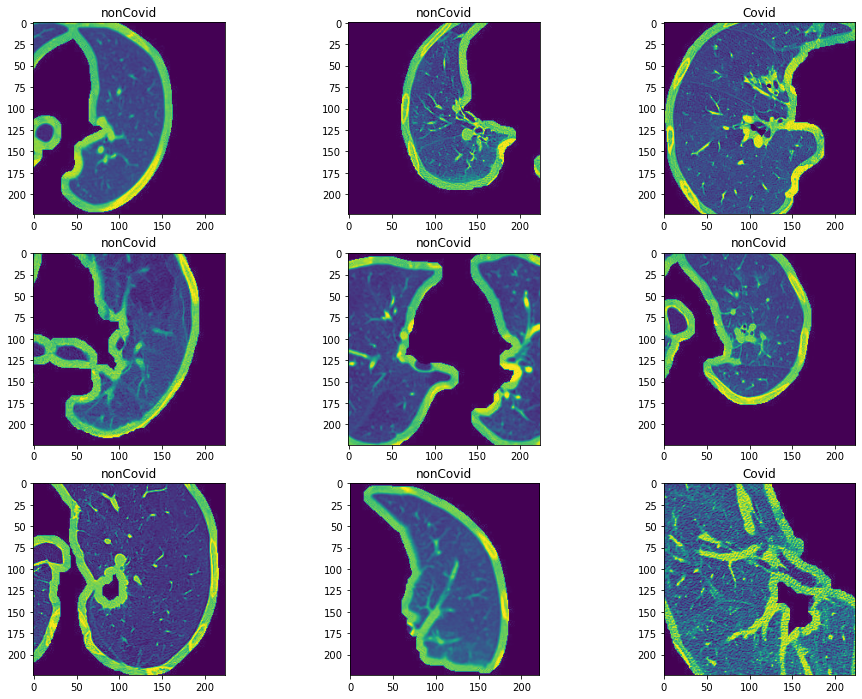

In [26]:
#Testing
"""
with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        #label = label.to(device)
        test_output = model(data) 
        #print('class=',torch.max(test_output[0],0))
        cls = torch.max(test_output[0],0)
        cls = cls.indices 
"""
## Newly added to check saved model
model = ViT(
    dim=1024,
    image_size=224,
    patch_size=32,
    num_classes=2,
    depth=12,
    heads=8,
    mlp_dim=1024,
   # transformer=efficient_transformer,
    channels=1,
).to(device)
pretrained_net = torch.load('xg_vit_model_covid_2d.pt')
model.load_state_dict(pretrained_net)

# saving the predicted results for test data
test_no = len(test_list)   #for train samples
#train_no = len(train_list)
print('test-no=',test_no)
with io.open('Vit-test-final-Mar23-Ep120.txt', 'w') as f:
    for idx in range(test_no):
       # img = Image.open(train_list[idx])
        img = Image.open(test_list[idx])
        img1 = TF.to_tensor(img)
        img2 = resize2d(img1,(224,224))
        #x = torch.zeros(1,3,224,224) ## for colour image wth 3 RGB channels
        x = torch.zeros(1,1,224,224)   ## for gray image
        x[0] = img2
        out = x[0]
        out.unsqueeze_(0)
        out = out.to('cuda:0')
        model.to('cuda:0')
        out.to(device)
        preds = model(out)
        print('class=',torch.max(preds[0],0))
        cls = torch.max(preds[0],0)
        cls = cls.indices
       # if cls>0:
           # f.write("%s\t%s\n" % (test_list[idx],'1'))
       # else:
           # f.write("%s\t%s\n" % (test_list[idx],'0'))
        if cls>0:
            f.write("%s\t%s\n" % (test_list[idx],'1'))
        else:
            f.write("%s\t%s\n" % (test_list[idx],'0'))
    
#Working on test data
random_idx = np.random.randint(1, len(test_list),size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(test_list[idx])
    #img = Image.open(train_list[idx])
    #ax.set_title(labels[idx])
    ax.imshow(img)
    #print('img-name=,', test_list[idx])
    img1 = TF.to_tensor(img)
    img2 = resize2d(img1,(224,224))
    x = torch.zeros(1,1,224,224) ## (1,1,224,224) for gray image and (1,3,224,224) for colour image
    x[0] = img2
    out = x[0]
    out.unsqueeze_(0)
    out = out.to('cuda:0')
    model.to('cuda:0')
    # out.to(device)
    preds = model(out)
    #print('class=',torch.max(preds[0],0))/
    cls = torch.max(preds[0],0)
    cls = cls.indices
    if cls>0:
        labels[idx] = 'Covid'
    else:
        labels[idx] = 'nonCovid'
    with io.open('Vit-test-9sample-Mar23-Ep120.txt', 'a') as f:
        f.write("%s\t%s\n" % (test_list[idx], labels[idx]))
    ax.set_title(labels[idx])